# Getting started

A lot of people get diagnosed with squamous cell carcinoma in the head & neck region ([HNSCC](https://en.wikipedia.org/wiki/Head_and_neck_cancer)), which frequently metastasizes via the lymphatic system. We set out to develop a methodology to predict the risk of a new patient having metastases in so-called lymph node levels (LNLs), based on their personal diagnose (e.g. findings from a CT scan) and information of previously diagnosed and treated patients. And that's exactly what this code enables you to do as well.

As mentioned, this package is meant to be a relatively simple-to-use frontend. The math is done under the hood and one does not need to worry about it a lot. But let's have a quick look at what we're doing here.

We will assume that you have already read the section on how to install the module and followed its instructions.

## Importing

First, let's import the package.

In [1]:
import lymph

## Graph

The model is based on the assumption that one can represent the lymphatic system as a directed graph. The arcs in that graph represent the direction of the lymphatic flow and therefore also the direction of metastatic spread. Hence, the first thing to do is to define a graph that represents the drainage pathways of the lymphatic system aptly.

Here, this is done via a dictionary:

In [2]:
graph = {('tumor', 'primary'): ['a', 'b'], 
         ('lnl'  , 'a'):       ['b', 'c'], 
         ('lnl'  , 'b'):       ['c'], 
         ('lnl'  , 'c'):       []}

Every key in this dictionary is a tuple of the form `({type}, {name})` and represents either a tumor - in which case the `{type}` must be `'tumor'` - or a lymph node level (`{type}` must be `'lnl'`). The value of each of those nodes is then a list of names for nodes it connects to. So, for example the primary tumor `('tumor', 'primary')` in the `graph` above has directed arcs to `a` and `b`, while the LNL `c` does not have any outgoing connections.

We can simply create an instance of `System` using only this graph and let it report itself:

In [3]:
simple_lymph_system = lymph.System(graph=graph)
print(simple_lymph_system)

Unilateral lymphatic system with 1 tumor(s) and 3 LNL(s).
primary-0.0%->a primary-0.0%->b a-0.0%->b a-0.0%->c b-0.0%->c


The percentages between two nodes represents the probability rate that metastatic spread occurs along it. In the case of the tumor spreading to LNL `a` we call this probability *base probability rate* $\tilde{b}_a$. For the spread between lymph node levels, we call it *transition probability rate*, e.g. $\tilde{t}_{ab}$. The difference to the base probability rate is that it only plays a role if the parent LNL is already ivolved with metastases, while the tumor always spreads, of course.

We can change these spread probability rates by setting the attribute `spread_probs` of the `System`. It can be set with an array of these spread sprobability rates.

In [4]:
simple_lymph_system.spread_probs = [0.1, 0.2, 0.4, 0.25, 0.05]
print(simple_lymph_system)

Unilateral lymphatic system with 1 tumor(s) and 3 LNL(s).
primary-10.0%->a primary-20.0%->b a-40.0%->b a-25.0%->c b-5.0%->c


Reversely, we can also read them out:

In [5]:
spread_probabilities = simple_lymph_system.spread_probs
print(spread_probabilities)

[0.1  0.2  0.4  0.25 0.05]


## Diagnostic Modalities

To ultimately compute the likelihoods of observations, we need to fix the sensitivities and specificities of the obtained diagnoses. And since we might have multiple diagnostic modalities available, we need to tell the system which of them comes with which specificity and sensitivity. We do this by creating a dictionary of specificity/sensitivity pairs:

In [6]:
mri_and_pet_spsn = {"MRI": [0.63, 0.81], 
                    "PET": [0.86, 0.79]}
#                           ^     ^
#                  specificty     sensitivity

Now we can pass this to the system by setting the `modalities` attribute, which expects a dictionary containing the diagnostic modalities and as a key to it the numbers for specificity & sensitivity.

In [7]:
simple_lymph_system.modalities = mri_and_pet_spsn

## Data / Observations

To compute the likelihood of a set of probability (rates) given a patient cohort we need such a patient cohort, of course. We can provide it to the system in the form of a `pandas` `DataFrame`. Here is an example:

In [8]:
import pandas as pd

dataset = pd.read_csv("_data/example.csv", header=[0,1])
dataset

info pathology          
    t_stage         I II III IV
0     early         1  0   0  0
1     early         0  1   0  0
2     early         0  1   0  0
3     early         0  1   0  0
4     early         0  1   0  0
..      ...       ... ..  .. ..
142   early         0  0   0  0
143   early         0  0   0  0
144   early         0  0   0  0
145   early         0  0   0  0
146   early         0  0   0  0

[147 rows x 5 columns]

Note that this data has two header-rows, defining not only the individual column's content, but also to which over-arching category they belong. The "Info" category plays a special role here along with its sub-category "T-stage". It will later tell the system which time prior to use according to a dictionary of these distributions.

The "pathology" section denotes that this dataset contains observations from a pathologic diagnostic modality (neck dissections in this case). How this is termed is irrelevant, as we will be telling the system what to look for. Import is, however, that - if we had multiple diagnostic modalities - they all contain a column for each lymph node level in the system we have set up. Obvioulsy, this dataset here does not match the system set up earlier, so let's fix that.

In [9]:
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl'  , 'I')  :       ['II'], 
         ('lnl'  , 'II') :       ['III'], 
         ('lnl'  , 'III'):       ['IV'],
         ('lnl'  , 'IV') :       []}

example_system = lymph.System(graph=graph)
print(example_system)

Unilateral lymphatic system with 1 tumor(s) and 4 LNL(s).
primary-0.0%->I primary-0.0%->II primary-0.0%->III primary-0.0%->IV I-0.0%->II II-0.0%->III III-0.0%->IV


To feed the dataset into the system, we assign the dataset to the attribute `patient_data`. What the system then does here is creating a $\mathbf{C}$ matrix for every T-stage in the data.

In [10]:
only_pathology = {"pathology": [1., 1.]}
example_system.modalities = only_pathology

example_system.patient_data = dataset

Lastly, the `mode` parameter determines which model should be used. We have implemented both the Bayesian network (`mode = "BN"`) from [(Pouymayou et al., 2019)](https://iopscience.iop.org/article/10.1088/1361-6560/ab2a18) and the hidden Markov model from our work (`mode = "HMM`). In case the Bayesian network is chosen, the parameter `t_stages` has no effect.

## Distribution over diagnose times

The last ingerdient to set up (at least when using the hidden Markov model) would now be the time prior. Since this dataset contains only early T-stage patients the exact shape does not matter too much, as long as it is "reasonable". If we also had late T-stage patients in the cohort, we would need to think about how the two time priors relate to each other.

For now we are going to use binomial distributions for this. Their shape makes intuitive sense: Since the time prior $p_T(t)$ is a distribution over the probability of diagnosing a patient after $t$ time steps, given his T-stage $T$ we would expect that a very early detection of the cancer is similarly unlikely as a very late one.

As mentioned, we need to put a distribution for each distinct T-stage in our cohort into a dictionary:

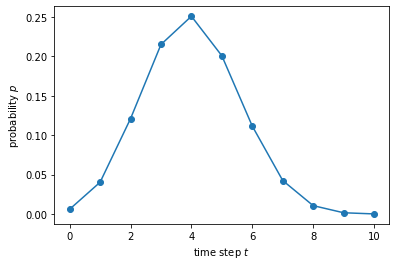

In [11]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

max_t = 10
time_steps = np.arange(max_t+1)
p = 0.4

early_prior = sp.stats.binom.pmf(time_steps, max_t, p)

plt.plot(time_steps, early_prior, "o-");
plt.xlabel("time step $t$");
plt.ylabel("probability $p$");

In [12]:
time_dists = {}
time_dists["early"] = early_prior

## Likelihood

With everything set up like this, we can compute the likelihood of seeing the above dataset given a set of base and transition probability (rates).

In [13]:
test_probabilities = np.array([0.02, 0.24, 0.03, 0.2, 0.23, 0.18, 0.18])

llh = example_system.marginal_log_likelihood(
    test_probabilities, t_stages=["early"], 
    time_dists=time_dists
)

print(f"log-likelihood is {llh:.2f}")

log-likelihood is -331.09


In [14]:
print(example_system)

Unilateral lymphatic system with 1 tumor(s) and 4 LNL(s).
primary-2.0%->I primary-24.0%->II primary-3.0%->III primary-20.0%->IV I-23.0%->II II-18.0%->III III-18.0%->IV


From here it is up to the user what to do with this quantity. Most *likely* though, one would want to perform MCMC sampling with this.